In [1]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Đọc dữ liệu
data_path = '/kaggle/input/ie403-doan/tiktok_comments_balanced.csv'
df = pd.read_csv(data_path, usecols=['emotion_label', 'text']).dropna()
df['emotion_label'] = df['emotion_label'].astype(int)
df['text'] = df['text'].astype(str)

In [ ]:
label_names = {
    0: 'Vui vẻ',
    1: 'Tức giận',
    2: 'Buồn bã',
    3: 'Sợ hãi',
    4: 'Trung lập'
}

In [ ]:
# Vector hóa văn bản
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])
y = df['emotion_label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)


In [5]:
# Khởi tạo các mô hình
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
svm = SVC(kernel='linear', probability=True, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Stacking (kết hợp các mô hình)
stacking_model = StackingClassifier(
    estimators=[
        ('lr', lr),
        ('svm', svm),
        ('rf', rf)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

models = {
    'Logistic Regression': lr,
    'SVM': svm,
    'Random Forest': rf,
    'Stacking (LR + SVM + RF)': stacking_model
}

In [ ]:
save_dir = "/kaggle/working/saved_models"
os.makedirs(save_dir, exist_ok=True)


🔹 Training model: Logistic Regression

📊 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Vui vẻ       0.55      0.57      0.56       276
    Tức giận       0.61      0.59      0.60       305
     Buồn bã       0.71      0.57      0.63       313
      Sợ hãi       0.81      0.79      0.80       276
   Trung lập       0.51      0.65      0.58       276

    accuracy                           0.63      1446
   macro avg       0.64      0.63      0.63      1446
weighted avg       0.64      0.63      0.63      1446



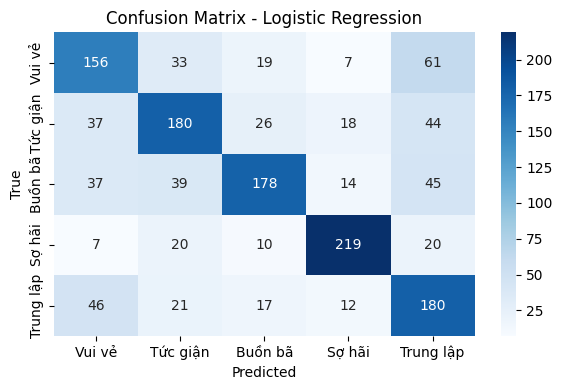


🔹 Training model: SVM

📊 Classification Report for SVM:
              precision    recall  f1-score   support

      Vui vẻ       0.54      0.58      0.56       276
    Tức giận       0.62      0.58      0.60       305
     Buồn bã       0.71      0.58      0.64       313
      Sợ hãi       0.80      0.79      0.79       276
   Trung lập       0.54      0.66      0.59       276

    accuracy                           0.63      1446
   macro avg       0.64      0.64      0.64      1446
weighted avg       0.64      0.63      0.64      1446



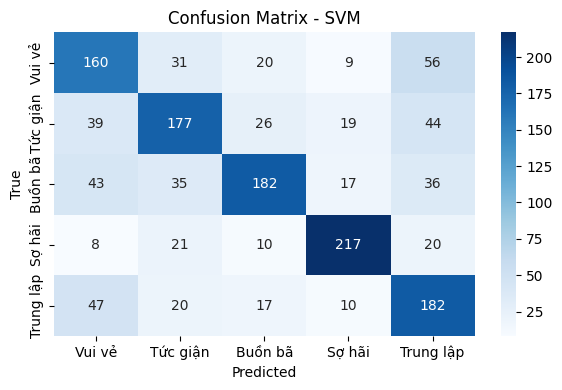


🔹 Training model: Random Forest

📊 Classification Report for Random Forest:
              precision    recall  f1-score   support

      Vui vẻ       0.55      0.46      0.50       276
    Tức giận       0.53      0.64      0.58       305
     Buồn bã       0.67      0.57      0.61       313
      Sợ hãi       0.81      0.77      0.79       276
   Trung lập       0.55      0.64      0.59       276

    accuracy                           0.61      1446
   macro avg       0.62      0.61      0.61      1446
weighted avg       0.62      0.61      0.61      1446



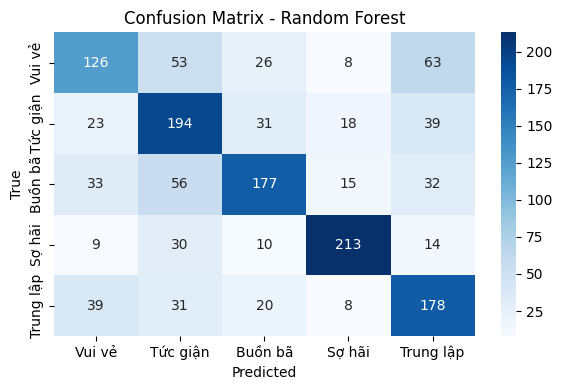


🔹 Training model: Stacking (LR + SVM + RF)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Classification Report for Stacking (LR + SVM + RF):
              precision    recall  f1-score   support

      Vui vẻ       0.59      0.54      0.56       276
    Tức giận       0.59      0.64      0.61       305
     Buồn bã       0.70      0.61      0.66       313
      Sợ hãi       0.80      0.80      0.80       276
   Trung lập       0.57      0.64      0.60       276

    accuracy                           0.65      1446
   macro avg       0.65      0.65      0.65      1446
weighted avg       0.65      0.65      0.65      1446



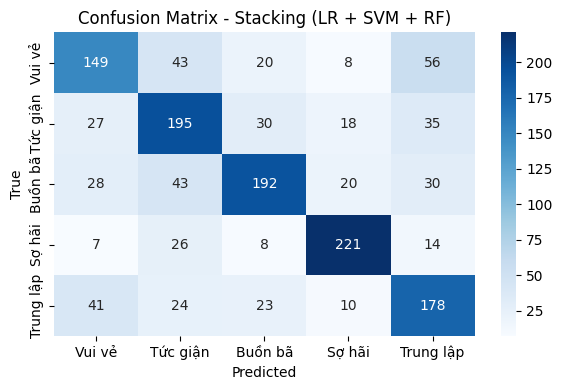

In [7]:
# ----- Huấn luyện & Lưu mô hình -----
for name, model in models.items():
    print(f"\n🔹 Training model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_val, y_pred, target_names=list(label_names.values())))

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names.values(),
                yticklabels=label_names.values())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Lưu mô hình
    joblib.dump(model, os.path.join(save_dir, f"{name}.pkl"))

In [ ]:
joblib.dump(vectorizer, os.path.join(save_dir, "tfidf_vectorizer.pkl"))

['/kaggle/working/saved_models/tfidf_vectorizer.pkl']

In [ ]:
def predict_emotion(text, model, vectorizer):
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    return label_names[pred]

In [ ]:
test_texts = [
    "nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺",
    "mày giỡn mặt tao à?",
    "trời ơi vui quá đi 😍 hôm nay được nghỉ học",
    "bạn nữ đó nhìn buồn thật sự",
    "tôi cảm thấy lo lắng khi ra đường bây giờ",
    "haiz, chẳng còn gì để nói nữa",
    "mấy bạn bình tĩnh, chuyện đâu còn có đó",
    "cảm ơn bạn rất nhiều vì đã giúp tôi",
    "tôi ghét cái cách bạn đối xử với tôi",
    "mình rất hồi hộp chờ kết quả thi"
]

In [11]:
print("\n--- Dự đoán cảm xúc với các mô hình đã huấn luyện ---")
vectorizer = joblib.load(os.path.join(save_dir, "tfidf_vectorizer.pkl"))

for model_name in models.keys():
    model = joblib.load(os.path.join(save_dir, f"{model_name}.pkl"))
    print(f"\n🔸 Mô hình: {model_name}")
    for text in test_texts:
        emotion = predict_emotion(text, model, vectorizer)
        print(f" \"{text}\" =>  {emotion}")


--- Dự đoán cảm xúc với các mô hình đã huấn luyện ---

🔸 Mô hình: Logistic Regression
 "nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺" =>  Buồn bã
 "mày giỡn mặt tao à?" =>  Tức giận
 "trời ơi vui quá đi 😍 hôm nay được nghỉ học" =>  Vui vẻ
 "bạn nữ đó nhìn buồn thật sự" =>  Buồn bã
 "tôi cảm thấy lo lắng khi ra đường bây giờ" =>  Sợ hãi
 "haiz, chẳng còn gì để nói nữa" =>  Buồn bã
 "mấy bạn bình tĩnh, chuyện đâu còn có đó" =>  Trung lập
 "cảm ơn bạn rất nhiều vì đã giúp tôi" =>  Vui vẻ
 "tôi ghét cái cách bạn đối xử với tôi" =>  Tức giận
 "mình rất hồi hộp chờ kết quả thi" =>  Vui vẻ

🔸 Mô hình: SVM
 "nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺" =>  Buồn bã
 "mày giỡn mặt tao à?" =>  Tức giận
 "trời ơi vui quá đi 😍 hôm nay được nghỉ học" =>  Vui vẻ
 "bạn nữ đó nhìn buồn thật sự" =>  Buồn bã
 "tôi cảm thấy lo lắng khi ra đường bây giờ" =>  Sợ hãi
 "haiz, chẳng còn gì để nói nữa" =>  Buồn bã
 "mấy bạn bình tĩnh, chuyện đâu còn có đó" =>  Trung lập
 "cảm